# <center>Welcome to 21cmFirstCLASS Notebook on Non Gaussianity!</center>
### <center>By S.Libanore, K. Finish, J. Bernal and J. Flitter </center>

#### In this notebook you will learn how to...
- Use non-Gaussian initial conditions

## General definitions

In [ ]:
# Import the packages required for this tutorial

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

import py21cmfast as p21c # To run 21cmFirstCLASS (21cmFAST)
from py21cmfast import plotting # For plotting global signals, coeval boxes, lightcone boxes and power spectra
import py21cmfast.power_spectrum as ps # Calculate power spectrum from the lightcone
from py21cmfast.inputs import global_params # Useful in this tutorial to plot the initial conditions for the simulation
from scipy.interpolate import interp1d
from functools import partial

from scipy.special import erfc
from classy import Class

-----------------------------------------------------
SarahLibanore: developing f_nl, C files updated with IC and fcoll in Lidz approximation on 02/28/2025
-----------------------------------------------------


It is VERY recommended for 21cmFirstCLASS users to have the 'latex' package installed in the same python environment where 21cmFirstCLASS is installed. <br>
If you have latex installed then you may run the next cell, otherwise do not run it as it will raise errors and no plots in this tutorial will be shown!

In [2]:
plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts

Define the color palette (this combination is good for colorblindness).

In [3]:
colors =  ['#377eb8', '#ff7f00', '#4daf4a',
           '#f781bf', '#a65628', '#984ea3',
           '#999999', '#e41a1c', '#dede00']

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

# PART 1:  Check the modeling functions

First of all, we test the functions that should be implemented in the main code to model the non Gaussian contribution. To do so, we need to initialize a CLASS run and obtain the matter power spectrum and transfer function.

TO CHECK: SHOULD WE ALSO SET FNL IN CLASS??? 

In [4]:
# Cosmological parameters in LCDM

cosmo_params = {"hlittle": 0.6736, # hubble parameter
                "OMb": 0.0493, # baryon density
                "OMm": 0.3153, # matter (CDM+baryon) density
                "A_s": 2.1e-9, # amplitude of the primordial fluctuations
                "POWER_INDEX": 0.9649, # spectral index of the primordial spectrum
                "tau_reio": 0.0544, # optical depth to reionization
                }

cosmo_params_fNL0 = {"hlittle": 0.6736, # hubble parameter
                "OMb": 0.0493, # baryon density
                "OMm": 0.3153, # matter (CDM+baryon) density
                "A_s": 2.1e-9, # amplitude of the primordial fluctuations
                "POWER_INDEX": 0.9649, # spectral index of the primordial spectrum
                "tau_reio": 0.0544, # optical depth to reionization
                "F_NL":0., # to test matching with old case
                }

cosmo_params_fNL = {"hlittle": 0.6736, # hubble parameter
                "OMb": 0.0493, # baryon density
                "OMm": 0.3153, # matter (CDM+baryon) density
                "A_s": 2.1e-9, # amplitude of the primordial fluctuations
                "POWER_INDEX": 0.9649, # spectral index of the primordial spectrum
                "tau_reio": 0.0544, # optical depth to reionization
                "F_NL":300., # to test matching with old case
                }


In [5]:
CLASS_params = {}
CLASS_params['h'] = cosmo_params_fNL0['hlittle']
CLASS_params['Omega_cdm'] = cosmo_params_fNL0['OMm'] - cosmo_params_fNL0['OMb']
CLASS_params['Omega_b'] = cosmo_params_fNL0['OMb']
CLASS_params['A_s'] = cosmo_params_fNL0['A_s']
CLASS_params['n_s'] = cosmo_params_fNL0['POWER_INDEX']
CLASS_params['output'] = 'tCl,pCl,lCl,mTk,vTk,mPk'
CLASS_params['lensing'] = 'yes'
CLASS_params['z_pk'] = 1087.
CLASS_params['l_max_scalars'] = 3000
# We need to run CLASS for very large wavenumbers. This is required for computing sigma(M) and the HMF
CLASS_params['P_k_max_1/Mpc'] = 1200.

# Run CLASS!
CLASS_OUTPUT = Class()
CLASS_OUTPUT.set(CLASS_params)
CLASS_OUTPUT.compute()

Transfer_0 = CLASS_OUTPUT.get_transfer(z=0.)
k_CLASS = Transfer_0['k (h/Mpc)'][:]*cosmo_params_fNL0['hlittle'] # 1/Mpc
delta_m_0_CLASS = Transfer_0['d_tot'][:]
k_output = pow(10.,np.array(global_params.LOG_K_ARR_FOR_TRANSFERS)) # 1/Mpc
delta_m_0 = p21c.generate_ICs.Interpolate_transfer(delta_m_0_CLASS,k_CLASS,k_output)

The matter and primordial potential overdensities are related via the Poisson equation. Estimating their transfer functions from CLASS we can transform one into the other; we show them in the next cells, accounting for the fact that the transfer functions that are output of CLASS have to be divided by $k^2$ to match the standard formalism.

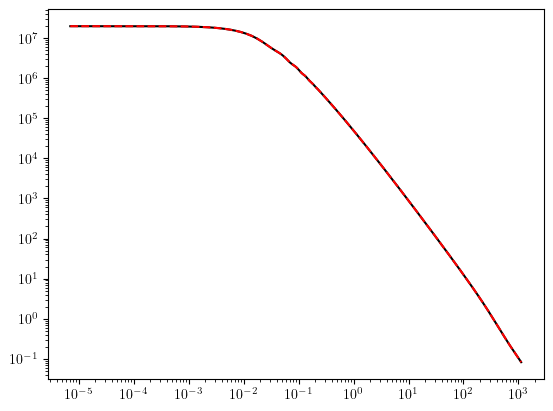

In [6]:
delta_pot_CLASS = Transfer_0['phi'][:] 
delta_pot = p21c.generate_ICs.Interpolate_transfer(delta_pot_CLASS,k_CLASS,k_output)

plt.loglog(k_output,delta_m_0/pow(k_output,2) ,'k')
plt.loglog(k_output,delta_pot/pow(k_output,2) * 2. * pow(29979245800.0/1e5*k_output,2) / 3. / cosmo_params_fNL0['OMm']/pow(cosmo_params_fNL0['hlittle']*100.,2),'r--')

We now define three point functions needed to model the non Gaussian corrections to $f_{\rm coll}$.

In [7]:
def FM(kv,MassVector,cosmo_params,global_params,kcutoff,fnl):

    rho_crit = 2.7754e11 * cosmo_params['hlittle']**2
    rhoM = rho_crit* cosmo_params['OMm']

    Mm = MassVector[None,None,:]
    Rm = (3.*Mm/(4.*np.pi*rhoM))**(1/3.)

    kall = pow(10.,np.array(global_params.LOG_K_ARR_FOR_TRANSFERS)) # 1/Mpc
    k = np.asarray(kall[[kall > kcutoff][0]])
    mu = np.linspace(-0.995, 0.995, 128) # cos theta

    k_2 = k[:, None, None]
    mu_val = mu[None,:,None]

    P_k1 =  9/25. * (2*np.pi**2/kv**3) * cosmo_params['A_s'] * (kv/0.05)**(cosmo_params['POWER_INDEX'] - 1.) # 9/25 is already in the transfer function from CLASS
    P_k2 =  9/25. * (2*np.pi**2/k_2**3) * cosmo_params['A_s'] * (k_2/0.05)**(cosmo_params['POWER_INDEX'] - 1.) # 9/25 is already in the transfer function from CLASS

    x2 = k_2*Rm
    Wm_k2 = 3.0*(np.sin(x2) - x2*np.cos(x2))/(x2)**3  # dimension k1, k2, mu, Mn, Mm
    dWm_k2 = (3 / np.power(x2, 2) * np.sin(x2) - 9 / np.power(x2, 4) * (np.sin(x2) - x2 * np.cos(x2))) * (x2) / (3 * Mm)

    k_CLASS = Transfer_0['k (h/Mpc)'][:]*cosmo_params['hlittle'] # 1/Mpc
    delta_m_0_CLASS = - 5/3. * Transfer_0['d_tot'][:]
    Tm_k1 = interp1d(k_CLASS, delta_m_0_CLASS, kind='cubic', bounds_error=False,fill_value=0.)(kv)
    Tm_k2 = interp1d(k_CLASS, delta_m_0_CLASS, kind='cubic', bounds_error=False,fill_value=0.)(k_2)

    k_12 = np.sqrt(pow(kv,2)+pow(k_2,2) + 2*kv*k_2*mu_val)
     
    Tm_k12 = interp1d(k_CLASS, delta_m_0_CLASS, kind='cubic', bounds_error=False,fill_value=0.)(k_12)

    x12 = k_12 * (3.*MassVector[None,None,:]/(4.*np.pi*rhoM))**(1/3.)
    sin_x12 = np.sin(x12)
    cos_x12 = np.cos(x12)
    Wm_k12 = 3.0*(sin_x12 - x12*cos_x12)/(x12)**3

    dWm_k12 =  (3 / np.power(x12, 2) * np.sin(x12) - 9 / np.power(x12, 4) * (np.sin(x12) - x12 * np.cos(x12))) * (x12) / (3 * Mm)

    P_k12 =  9/25. * (2*np.pi**2/k_12**3) * cosmo_params['A_s'] * (k_12/0.05)**(cosmo_params['POWER_INDEX'] - 1.)

    integrand = k_2**2 * Wm_k2 * Tm_k2 * Wm_k12 * Tm_k12 * (P_k1 * P_k2 + P_k2 * P_k12 + P_k1 * P_k12)
    
    integral_dk2 = np.trapz(integrand, k, axis = 0)
    Fm = np.trapz(integral_dk2, mu, axis = 0)

    Fm *= 2. * fnl / (8*np.pi**4.) * Tm_k1

    integrand_dn2 = k_2**2 * Tm_k2 * Tm_k12 * (P_k1 * P_k2 + P_k2 * P_k12 + P_k1 * P_k12) * (dWm_k2 * Wm_k12 + Wm_k2 * dWm_k12)
    
    integral_dk2_dn2 = np.trapz(integrand_dn2, k, axis = 0)
    dFm_dn2 = np.trapz(integral_dk2_dn2, mu, axis = 0)
    
    dFm_dn2 *= 2. * fnl / (8*np.pi**4.) * Tm_k1

    return [Fm, dFm_dn2]

def tpf(MassVector,cosmo_params,global_params,kcutoff,fnl):

    kall = pow(10.,np.array(global_params.LOG_K_ARR_FOR_TRANSFERS)) # 1/Mpc
    k = np.asarray(kall[[kall > kcutoff][0]])

    rho_crit = 2.7754e11 * cosmo_params['hlittle']**2
    rhoM = rho_crit* cosmo_params['OMm']    
    
    k_1 = k[:,None]

    FM_function = lambda kv: FM(kv,MassVector=MassVector,cosmo_params=cosmo_params,global_params=global_params,kcutoff=kcutoff,fnl=fnl)
    temp = np.apply_along_axis(FM_function, axis=-1, arr=k_1)
    Fm = temp[:,0,:][:,None,:]
    dFm_dn2 = temp[:,1,:][:,None,:]

    k_1 = k[:,None,None]
    Mn = MassVector[None,:,None]
    Rn = (3.*Mn/(4.*np.pi*rhoM))**(1/3.)
    x1 = k_1*Rn
    Wn_k1 = 3.0*(np.sin(x1) - x1*np.cos(x1))/(x1)**3 
    dWn_k1 = (3 / np.power(x1, 2) * np.sin(x1) - 9 / np.power(x1, 4) * (np.sin(x1) - x1 * np.cos(x1))) * (x1) / (3 * Mn)
    integrand = k_1 ** 2 * Wn_k1 * Fm

    ddd = np.trapz(integrand,k,axis=0)

    integrand_dnm2 = k_1 ** 2 * dWn_k1 * Fm
    integrand_dmn2 = k_1 ** 2 * Wn_k1 * dFm_dn2
    integrand_dn3 = k_1 ** 2 * (dWn_k1 * Fm + Wn_k1 * dFm_dn2)

    der_dnm2 = np.trapz(integrand_dnm2,k,axis=0)
    der_dmn2 = np.trapz(integrand_dmn2,k,axis=0)
    der_dn3 = np.trapz(integrand_dn3,k,axis=0)

    der_ddd = np.zeros((len(MassVector),len(MassVector)))
    # Fill below the diagonal (i > j) with n2m
    der_ddd[np.tril_indices(len(MassVector), -1)] = der_dmn2[np.tril_indices(len(MassVector), -1)]

    # Fill above the diagonal (i < j) with nm2
    der_ddd[np.triu_indices(len(MassVector), 1)] = der_dnm2[np.triu_indices(len(MassVector), 1)]

    # Fill the diagonal with nnn
    np.fill_diagonal(der_ddd, np.diagonal(der_dn3))

    return ddd, der_ddd

We now test the three point function. First, we define the matrix of the $\langle\delta_n\delta_m^2\rangle$ where $n,m$ are associated with two different masses. In the $f_{\rm coll}$ computation, we always have $M_n<M_m$, hence we define the matrix such that on the upper triangular part we have $\langle\delta_n\delta_m^2\rangle$, while the lower triangular is $\langle\delta_n^2\delta_m\rangle$ and the diagonal $\langle\delta_{n,m}^3\rangle$.

In [8]:
log10_M_array = np.linspace(4.,20.,300)
rho_crit = 2.7754e11 * cosmo_params['hlittle']**2
rhoM = rho_crit* cosmo_params['OMm']

fnl = 300 
nmm_004 = tpf(pow(10.,log10_M_array),cosmo_params,global_params,kcutoff=0.04,fnl=fnl)[0]
nmm_1 = tpf(pow(10.,log10_M_array),cosmo_params,global_params,kcutoff=1.,fnl=fnl)[0]
sigma_0_fast = np.zeros((len(log10_M_array)))
k3_004 = np.zeros(len(log10_M_array))
nnn_004 = np.zeros((len(log10_M_array)))
k3_1 = np.zeros(len(log10_M_array))
nnn_1 = np.zeros((len(log10_M_array)))

for Mn_ind, Mn in enumerate(pow(10.,log10_M_array)):
    nnn_004[Mn_ind] = nmm_004[Mn_ind,Mn_ind]
    nnn_1[Mn_ind] = nmm_1[Mn_ind,Mn_ind]
    sigma_0_fast[Mn_ind] = CLASS_OUTPUT.sigma((3.*Mn/(4.*np.pi*rhoM))**(1/3.),0.)
    k3_004[Mn_ind] = nnn_004[Mn_ind]/sigma_0_fast[Mn_ind]**3.
    k3_1[Mn_ind] = nnn_1[Mn_ind]/sigma_0_fast[Mn_ind]**3.

Now we compare quantities with previous papers.

(0.0, 5.0)

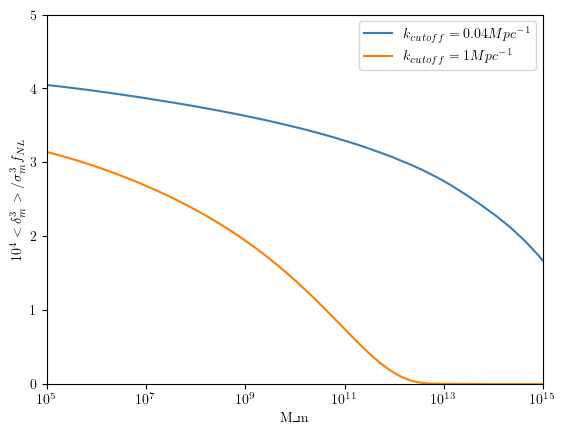

In [9]:
# compare in Fig 4 in Sabti Munoz
plt.semilogx(pow(10.,log10_M_array),1e4*k3_004 /fnl,label=r'$k_{cutoff}=0.04 Mpc^{-1}$' )
plt.semilogx(pow(10.,log10_M_array),1e4*k3_1 /fnl ,label=r'$k_{cutoff}=1 Mpc^{-1}$')
plt.legend()
plt.xlabel(r'M_m')
plt.ylabel(r'$10^4<\delta_m^3>/\sigma_m^3f_{NL}$')
plt.xlim(1e5,1e15)
plt.ylim(0,5)

In [10]:
fnl = 300 
nmm_fast, der_nmm_fast = tpf(pow(10.,log10_M_array),cosmo_params,global_params,kcutoff=0.01,fnl=fnl)
nnn_fast = np.zeros((len(log10_M_array)))
der_nnn_fast = np.zeros((len(log10_M_array)))

for Mn_ind, Mn in enumerate(pow(10.,log10_M_array)):
    nnn_fast[Mn_ind] = nmm_fast[Mn_ind,Mn_ind]
    der_nnn_fast[Mn_ind] = der_nmm_fast[Mn_ind,Mn_ind]

(0.0, 10.0)

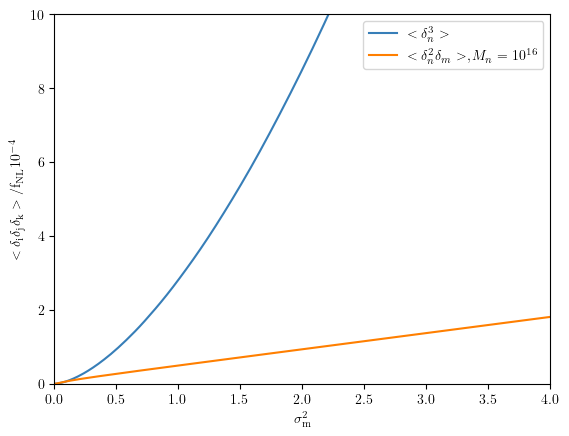

In [11]:
# compare with Fig 1 in D'Alosio
id = 225
plt.plot(sigma_0_fast**2,nnn_fast/fnl/1e-4 ,label=r'$<\delta_n^3>$')
plt.plot(sigma_0_fast**2,nmm_fast[id,:]/fnl/1e-4,label=r'$<\delta_n^2\delta_m>,M_n = 10^{%g}$'%round(log10_M_array[id],1))
plt.xlabel(r'$\rm \sigma^2_m$')
plt.ylabel(r'$\rm <\delta_i\delta_j\delta_k>/f_{NL}10^{-4}$')
plt.legend()
plt.xlim(0,4)
plt.ylim(0,10)

At this point, we compute $f_{\rm coll}$ and $df_{\rm coll}/dM_{\rm min}$ following both D'Alosio and Lidz. We want to understand if the Lidz approximation is good, and if and where it breaks.

In [12]:
def fcoll_DALOSIO(M1_id,M2_id,tpf,z):

    M1 = 10**log10_M_array[M1_id]
    M2 = 10**log10_M_array[M2_id]
    
    Rn = (3.*M1/(4.*np.pi*rhoM))**(1/3.)
    Rm = (3.*M2/(4.*np.pi*rhoM))**(1/3.)

    sigma1 = CLASS_OUTPUT.sigma(Rn,0.)
    sigma2 = CLASS_OUTPUT.sigma(Rm,0.)

    growthf = CLASS_OUTPUT.scale_independent_growth_factor(z)
    delta1 = 1.68
    sigma1 = sigma1*sigma1
    sigma2 = sigma2*sigma2
    delta2 = np.sqrt(sigma2) * growthf

    deltagrowth_diff = ( delta1 - delta2 )/growthf
    if (sigma1 < sigma2):
        return 0.,0.
    elif (sigma1 > sigma2):
        sigma_diff = sigma1 - sigma2
    elif (sigma1==sigma2):
        sigma_diff = 1.e-6
        
    fcoll_dMmin_EPS = erfc((deltagrowth_diff)/np.sqrt( 2.*sigma_diff ) )

    delta_n3 = tpf[M1_id,M1_id]
    delta_m3 = tpf[M2_id,M2_id] 
    delta_m2delta_n = tpf[M1_id,M2_id]
    delta_mdelta_n2 = tpf[M2_id,M1_id]

    A = (delta_n3 - delta_m3 + 3.*delta_m2delta_n - 3.*delta_mdelta_n2)
    B = (delta_m3 + delta_mdelta_n2 - 2*delta_m2delta_n)
    Cval = (delta_m2delta_n - delta_m3)

    dfcoll_G_dSn = deltagrowth_diff / np.sqrt(2*np.pi) / pow(sigma_diff,3/2.) * np.exp(-pow(deltagrowth_diff,2)/2./sigma_diff); 

    val = ( pow(delta1 / growthf, 2) - delta1 * delta2 / pow(growthf,2)) / sigma2 ; 
    cothD = (np.exp(val) + np.exp(-val)) / (np.exp(val) - np.exp(-val)); 

    one_dSn = A/3. * (
         deltagrowth_diff / sigma_diff - 1./deltagrowth_diff )* dfcoll_G_dSn

    two_dSn = B/sigma2 * ( delta1 / growthf - deltagrowth_diff * cothD ) * dfcoll_G_dSn 

    three_dSn = Cval*sigma_diff/(pow(sigma2,2) * deltagrowth_diff ) * (pow(delta2 / growthf, 2.) - sigma2 - 2. * (pow(delta1 / growthf,2)-delta1*delta2/pow(growthf,2)) * (cothD -1.)) * dfcoll_G_dSn  

    if (delta1 <= delta2 or pow(delta1/growthf,2) < sigma2 or sigma2 == 0.):
        fcoll_dMmin_NG = 0.
    else:
        fcoll_dMmin_NG = (one_dSn + two_dSn + three_dSn)
    
    return fcoll_dMmin_EPS , fcoll_dMmin_NG 


In [13]:
def fcoll(M1_id,M2_id,tpf,z):

    M1 = 10**log10_M_array[M1_id]
    M2 = 10**log10_M_array[M2_id]
    sigma1 = CLASS_OUTPUT.sigma((3.*M1/(4.*np.pi*rhoM))**(1/3.),0.)
    sigma2 = CLASS_OUTPUT.sigma((3.*M2/(4.*np.pi*rhoM))**(1/3.),0.)

    growthf = CLASS_OUTPUT.scale_independent_growth_factor(z)
    delta1 = 1.68
    sigma1 = sigma1*sigma1
    sigma2 = sigma2*sigma2
    delta2 = np.sqrt(sigma2) * growthf

    deltagrowth_diff = ( delta1 - delta2 )/growthf
    if (sigma1 < sigma2):
        return 0.,0.
    elif (sigma1 > sigma2):
        sigma_diff = sigma1 - sigma2
    elif (sigma1==sigma2):
        sigma_diff = 1.e-6
        
    fcoll_dMmin_EPS = erfc((deltagrowth_diff)/np.sqrt( 2.*sigma_diff ) )

    delta_n3 = tpf[M1_id,M1_id]
    delta_m3 = tpf[M2_id,M2_id] 
    delta_m2delta_n = tpf[M1_id,M2_id]
    delta_mdelta_n2 = tpf[M2_id,M1_id]

    A = (delta_n3 - delta_m3 + 3.*delta_m2delta_n - 3.*delta_mdelta_n2)
    B = (delta_m3 + delta_mdelta_n2 - 2*delta_m2delta_n)

    if (delta1 <= delta2 or pow(delta1/growthf,2) < sigma2 or sigma2 == 0.):
        fcoll_dMmin_NG = 0.
    else:
        fcoll_dMmin_NG = np.exp(-pow(deltagrowth_diff,2)/2./sigma_diff) * (A / 3./np.sqrt(2*np.pi)/sigma_diff**(3/2.)*(deltagrowth_diff**2/sigma_diff - 1.)+ B*delta2/growthf/sigma2*deltagrowth_diff/np.sqrt(2*np.pi)/sigma_diff**(3/2.))
        

    return fcoll_dMmin_EPS , fcoll_dMmin_NG 


/tmp/ipykernel_41794/3119530117.py:30: RuntimeWarning: invalid value encountered in divide
  plt.semilogx(pow(10,log10_M_array) ,(out+outNGDA)/out,'r-')
/tmp/ipykernel_41794/3119530117.py:31: RuntimeWarning: invalid value encountered in divide
  plt.semilogx(pow(10,log10_M_array),(out+outNG)/out,'b--')


Text(0, 0.5, '($f^G_{coll}+f^{NG}_{coll}) / f^G_{coll}$')

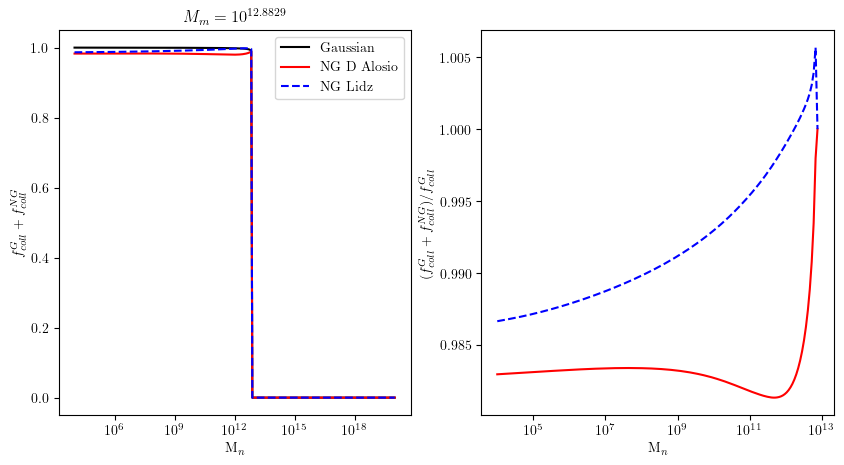

In [14]:
# compare with Fig 2 D'Alosio

Mm_ind = 166 #225
funct = lambda Mv: fcoll(Mv,Mm_ind,nmm_fast,z=0.)
functDA = lambda Mv: fcoll_DALOSIO(Mv,Mm_ind,nmm_fast,z=0.)
out = np.zeros((len(log10_M_array)))
outDA = np.zeros((len(log10_M_array)))
outNG = np.zeros((len(log10_M_array)))
outNGDA = np.zeros((len(log10_M_array)))
for i in range(len(log10_M_array)):
    temp = funct(i)
    out[i] = temp[0]
    outNG[i] = temp[1]
    temp = functDA(i)
    outNGDA[i] = temp[1]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.semilogx(pow(10,log10_M_array),(out),'k-',label='Gaussian')
plt.semilogx(pow(10,log10_M_array),(outNGDA+out),'r-',label='NG D Alosio')
plt.semilogx(pow(10,log10_M_array),(outNG+out),'b--',label = 'NG Lidz')
#plt.xlim(1e12,1e15)
plt.xlabel(r'M$_n$')
plt.ylabel(r'$f^G_{coll}+f^{NG}_{coll}$')
plt.legend(loc=1)
#plt.ylim(0,0.6)
plt.title(r'$M_m=10^{%g}$'%log10_M_array[Mm_ind])

plt.subplot(122)
plt.semilogx(pow(10,log10_M_array) ,(out+outNGDA)/out,'r-')
plt.semilogx(pow(10,log10_M_array),(out+outNG)/out,'b--')
#plt.xlim(1e12,1e15)
#plt.ylim(0.9,1.1)
plt.xlabel(r'M$_n$')
plt.ylabel(r'($f^G_{coll}+f^{NG}_{coll}) / f^G_{coll}$')


In C code we need to implement the derivative of $f_{\rm coll}$. Here we implement it in the full D'Alosio expression and in the Lidz approximation.

In [15]:
def dfcoll_dAlosio():

    return

In [16]:
def dfcoll(M1_id,M2_id,tpf,der,z):

    M1 = 10**log10_M_array[M1_id]
    M2 = 10**log10_M_array[M2_id]
    sigma1 = CLASS_OUTPUT.sigma((3.*M1/(4.*np.pi*rhoM))**(1/3.),0.)
    sigma2 = CLASS_OUTPUT.sigma((3.*M2/(4.*np.pi*rhoM))**(1/3.),0.)

    dsigma_2_dlog10_M = (CLASS_OUTPUT.sigma((3.*(M1*10.**0.1)/(4.*np.pi*rhoM))**(1/3.),0.) - sigma1)/0.1
    dsigmadm =2.*sigma1/(np.log(10.)*M1)*dsigma_2_dlog10_M

    growthf = CLASS_OUTPUT.scale_independent_growth_factor(z)
    delta1 = 1.68
    sigma1 = sigma1*sigma1
    sigma2 = sigma2*sigma2
    delta2 = np.sqrt(sigma2) * growthf
 
    deltagrowth_diff = ( delta1 - delta2 )/growthf
    if (sigma1 < sigma2):
        return 0.,0.
    elif (sigma1 > sigma2):
        sigma_diff = sigma1 - sigma2
    elif (sigma1==sigma2):
        sigma_diff = 1.e-6
        
    dfcoll_dMmin_EPS = (-(deltagrowth_diff)*dsigmadm *( np.exp( - pow( deltagrowth_diff, 2 )/( 2.*sigma_diff ) ) )/(pow(sigma_diff, 1.5)))/np.sqrt(np.pi*2)

    delta_n3 = tpf[M1_id,M1_id]
    delta_m3 = tpf[M2_id,M2_id] 
    delta_m2delta_n = tpf[M1_id,M2_id]
    delta_mdelta_n2 = tpf[M2_id,M1_id]

    ddelta_n3_dMmin = der[M1_id,M1_id]
    ddelta_m2delta_n_dMin = der[M1_id,M2_id]
    ddelta_mdelta_n2_dMin = der[M2_id,M1_id]

    A = (delta_n3 - delta_m3 + 3.*delta_m2delta_n - 3.*delta_mdelta_n2)
    B = (delta_m3 + delta_mdelta_n2 - 2*delta_m2delta_n)

    dA_dMmin = (ddelta_n3_dMmin + 3.*ddelta_m2delta_n_dMin - 3.*ddelta_mdelta_n2_dMin)
    dB_dMmin = (ddelta_mdelta_n2_dMin - 2.*ddelta_m2delta_n_dMin) 

    if (delta1 <= delta2 or pow(delta1/growthf,2) < sigma2 or sigma2 == 0.):
        dfcoll_dMmin_NG = 0.
    else:
        dfdS = (deltagrowth_diff/np.sqrt(2*np.pi)/pow(sigma_diff,3/2.)) * np.exp(-pow(deltagrowth_diff,2)/2./sigma_diff);

        ddfdSdM = dfdS * dsigmadm / 2. / sigma_diff * (pow(deltagrowth_diff,2.)/sigma_diff - 3.);

        term = delta2 / growthf / sigma2;

        one = A / 3. * (deltagrowth_diff / sigma_diff - 1. / deltagrowth_diff) + B * term;

        two = dA_dMmin / 3. * (deltagrowth_diff / sigma_diff - 1. / deltagrowth_diff) - A / 3. * dsigmadm * (deltagrowth_diff / pow(sigma_diff,2.)) + dB_dMmin * term ;

        dfcoll_dMmin_NG = - (ddfdSdM * one + dfdS * two);

    return dfcoll_dMmin_EPS , dfcoll_dMmin_NG 


/tmp/ipykernel_41794/2519038895.py:22: RuntimeWarning: invalid value encountered in divide
  plt.semilogx(pow(10,log10_M_array)[np.where(dout!=0.)],((dout+doutNG)/dout)[np.where(dout!=0.)],'b--')


Text(0, 0.5, '($d(f^G_{coll}+f^{NG}_{coll})/dM_{min} / df^G_{coll}/dM_{min}$')

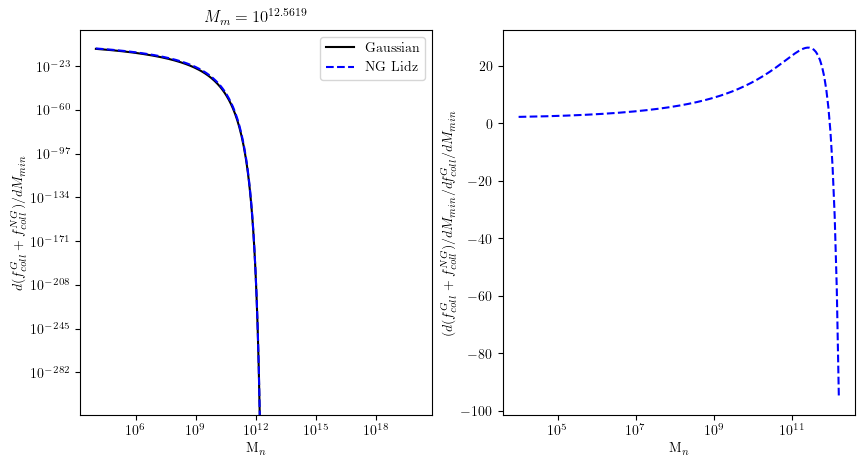

In [17]:
Mm_ind = 160#225
dfunct = lambda Mv: dfcoll(Mv,Mm_ind,nmm_fast,der_nmm_fast, z=30.)
dout = np.zeros((len(log10_M_array)))
doutNG = np.zeros((len(log10_M_array)))
for i in range(len(log10_M_array)):
    temp = dfunct(i)
    dout[i] = temp[0]
    doutNG[i] = temp[1]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.loglog(pow(10,log10_M_array),abs(dout),'k-',label='Gaussian')
plt.loglog(pow(10,log10_M_array),abs(doutNG+dout),'b--',label = 'NG Lidz')
#plt.xlim(1e12,1e15)
plt.xlabel(r'M$_n$')
plt.ylabel(r'$d (f^G_{coll}+f^{NG}_{coll})/dM_{min}$')
plt.legend(loc=1)
#plt.ylim(0,0.6)
plt.title(r'$M_m=10^{%g}$'%log10_M_array[Mm_ind])

plt.subplot(122)
plt.semilogx(pow(10,log10_M_array)[np.where(dout!=0.)],((dout+doutNG)/dout)[np.where(dout!=0.)],'b--')
#plt.xlim(1e12,1e15)
#plt.ylim(0.9,1.1)
plt.xlabel(r'M$_n$')
plt.ylabel(r'($d(f^G_{coll}+f^{NG}_{coll})/dM_{min} / df^G_{coll}/dM_{min}$')

# PART 2: RUN THE SIMULATIONS

## Set up parameters for the simulation

We run four simulations:
1) using the original 21cmFC code in the Gaussian case
2) using our modified version but with $f_{NL}=0$ (sanity check)
3) using our modified version with non Gaussianity only in the initial conditions 
4) using our modified version with non Gaussianity only in the collapse fraction corrections

In [18]:
# Parameters related with the size of the simulation itself and with the kind of outputs required

user_params = {"BOX_LEN": 100, # size of the simulated box (in comoving Mpc) 
               "HII_DIM": 25, # number of cells along each axis of the coeval box - Note: more cells means longer runtime! 
               "N_THREADS": 6} # the amount of processors the code uses in parallelization

user_params_NG_IC = {"BOX_LEN": 100, # size of the simulated box (in comoving Mpc) 
               "HII_DIM": 25, # number of cells along each axis of the coeval box - Note: more cells means longer runtime! 
               "N_THREADS": 6, # the amount of processors the code uses in parallelization
               "NON_GAUSS_IC":True, # use non gaussian field in initial conditions
               "NON_GAUSS_FCOLL":False} # use non gaussian field in collapsed fraction

user_params_NG_FCOLL = {"BOX_LEN": 100, # size of the simulated box (in comoving Mpc) 
               "HII_DIM": 25, # number of cells along each axis of the coeval box - Note: more cells means longer runtime! 
               "N_THREADS": 6, # the amount of processors the code uses in parallelization
               "USE_INTERPOLATION_TABLES": True, # if False, no Fcoll correction implementation TO BE CHANGED
               "EVOLVE_MATTER":True, # if False, no Fcoll correction implementation TO BE CHANGED
               "NON_GAUSS_IC":False, # use non gaussian field in initial conditions
               "NON_GAUSS_FCOLL":True} # use non gaussian field in collapsed fraction

user_params_NG = {"BOX_LEN": 100, # size of the simulated box (in comoving Mpc) 
               "HII_DIM": 25, # number of cells along each axis of the coeval box - Note: more cells means longer runtime! 
               "N_THREADS": 6, # the amount of processors the code uses in parallelization
               "USE_INTERPOLATION_TABLES": True, # if False, no Fcoll correction implementation TO BE CHANGED
               "EVOLVE_MATTER":True, # if False, no Fcoll correction implementation TO BE CHANGED
               "NON_GAUSS_IC":True, # use non gaussian field in initial conditions
               "NON_GAUSS_FCOLL":True} # use non gaussian field in collapsed fraction

In [19]:
# Parameters that set the physical processes the code accounts for

flag_options = {"USE_MINI_HALOS": False, } # if False, popIII stars are not included - Note: if set to True, the runtime increases significantly!

In [20]:
# Astrophysical parameters in a standard scenario
# some parameters require to input the log10 value

astro_params = {"F_STAR10": -1.25, # star formation efficiency (atomic cooling galaxies) for pivot mass 1e10 Msun (log10)
                "ALPHA_STAR": 0.5, # slope of the dependency of star formation efficiency on the host halo mass 
                "F_ESC10": -1.35, # escape fraction of Lyman photons into the IGM for pivot mass 1e10 Msun (log10)
                "ALPHA_ESC": -0.3, # slope of the dependency of escape fraction on the host halo mass 
                "L_X": 40.5, # X-ray luminosity (log10)
        
# popIII stars parameters -- use only if USE_MINI_HALOS = True    
                #"F_STAR7_MINI": -2.5, # star formation efficiency (molecular cooling galaxies) for pivot mass 1e7 Msun (log10)
                #"ALPHA_STAR_MINI": 0., # slope of the dependency of star formation efficiency on the host halo mass 
                #"F_ESC7_MINI": -1.35, # escape fraction of Lyman photons into the IGM for molecular cooling galaxies, assumed constant as function of the halo mass (log10)
                # "L_X_MINI": 40.5, # Xray luminosity 
}


### Set up the required outputs

As in 21cmFAST, 21cmFirstCLASS allows you to extract the quantities evolved in the simulation using different formats.

- global quantity: store the quantity averaged over the full box, as a function of redshift 
- coeval boxes: store the box in which the quantity is computed at fixed redshift (you need to specify which redshift)
- lightcone quantity: store the quantity along the line-of-sight, to study how it evolves as a function of both space and time/redshift 

In principle, you can use the same key words in all the output kinds. <br>
Note however that the more lightcones and coeval boxes are stored, the more memory space is required.

In [21]:
global_quantities = ("brightness_temp", # brightness temperature
                     "Tk_box", # kinetic temperature
                     "Ts_box", # spin temperature
                     "xH_box", # neutral hydrogen fraction
                     "J_Lya_box", # Lyman alpha flux - new feature in 21cmFirstCLASS! 
                     "x_e_box") # free electron fraction

In [22]:
coeval_quantities = ["density", # matter density fluctuations 
                     "brightness_temp"]

input_coeval_redshifts = [6., 
                          10., 
                          15.]

In [23]:
lightcone_quantities = ("brightness_temp",
                        "density")

## Run the simulation

In [24]:
lightcone = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                               random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                               regenerate = True, # create new data even if cached are found
                               write = False, # whether or no to save cached files
                               user_params = user_params,
                               astro_params = astro_params, 
                               flag_options = flag_options,
                               cosmo_params = cosmo_params,
                               global_quantities = global_quantities,
                               save_coeval_quantities = coeval_quantities,
                               save_coeval_redshifts = input_coeval_redshifts,
                               lightcone_quantities = lightcone_quantities) ; 

Now running CLASS...
Now generating initial boxes...
boxes->hires_density=1.258004e+00


21cmFAST (cosmic dawn): 100%|██████████| 84/84 [01:37<00:00,  1.16s/redshift]


Now evaluating tau to reionization and re-running CLASS...


In [25]:
lightcone_fNL0 = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                               random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                               regenerate = True, # create new data even if cached are found
                               write = False, # whether or no to save cached files
                               user_params = user_params_NG,
                               astro_params = astro_params, 
                               flag_options = flag_options,
                               cosmo_params = cosmo_params_fNL0,
                               global_quantities = global_quantities,
                               save_coeval_quantities = coeval_quantities,
                               save_coeval_redshifts = input_coeval_redshifts,
                               lightcone_quantities = lightcone_quantities) ; 

Now running CLASS...
Computing three point functions to estimate the Fcoll NG corrections...
Now generating initial boxes...
boxes->hires_density=1.257609e+00


21cmFAST (cosmic dawn): 100%|██████████| 84/84 [01:34<00:00,  1.12s/redshift]


Now evaluating tau to reionization and re-running CLASS...


In [26]:
lightcone_fNL_IC = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                               random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                               regenerate = True, # create new data even if cached are found
                               write = False, # whether or no to save cached files
                               user_params = user_params_NG_IC,
                               astro_params = astro_params, 
                               flag_options = flag_options,
                               cosmo_params = cosmo_params_fNL,
                               global_quantities = global_quantities,
                               save_coeval_quantities = coeval_quantities,
                               save_coeval_redshifts = input_coeval_redshifts,
                               lightcone_quantities = lightcone_quantities) ; 

Now running CLASS...
Now generating initial boxes...
boxes->hires_density=2.249143e+00


21cmFAST (cosmic dawn): 100%|██████████| 84/84 [01:30<00:00,  1.08s/redshift]


Now evaluating tau to reionization and re-running CLASS...


In [27]:
lightcone_fNL_FCOLL = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                               random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                               regenerate = True, # create new data even if cached are found
                               write = False, # whether or no to save cached files
                               user_params = user_params_NG_FCOLL,
                               astro_params = astro_params, 
                               flag_options = flag_options,
                               cosmo_params = cosmo_params_fNL,
                               global_quantities = global_quantities,
                               save_coeval_quantities = coeval_quantities,
                               save_coeval_redshifts = input_coeval_redshifts,
                               lightcone_quantities = lightcone_quantities) ; 

Now running CLASS...
Computing three point functions to estimate the Fcoll NG corrections...
Now generating initial boxes...
boxes->hires_density=1.258004e+00


21cmFAST (cosmic dawn): 100%|██████████| 84/84 [02:02<00:00,  1.46s/redshift]


Now evaluating tau to reionization and re-running CLASS...


Text(0, 0.5, '')

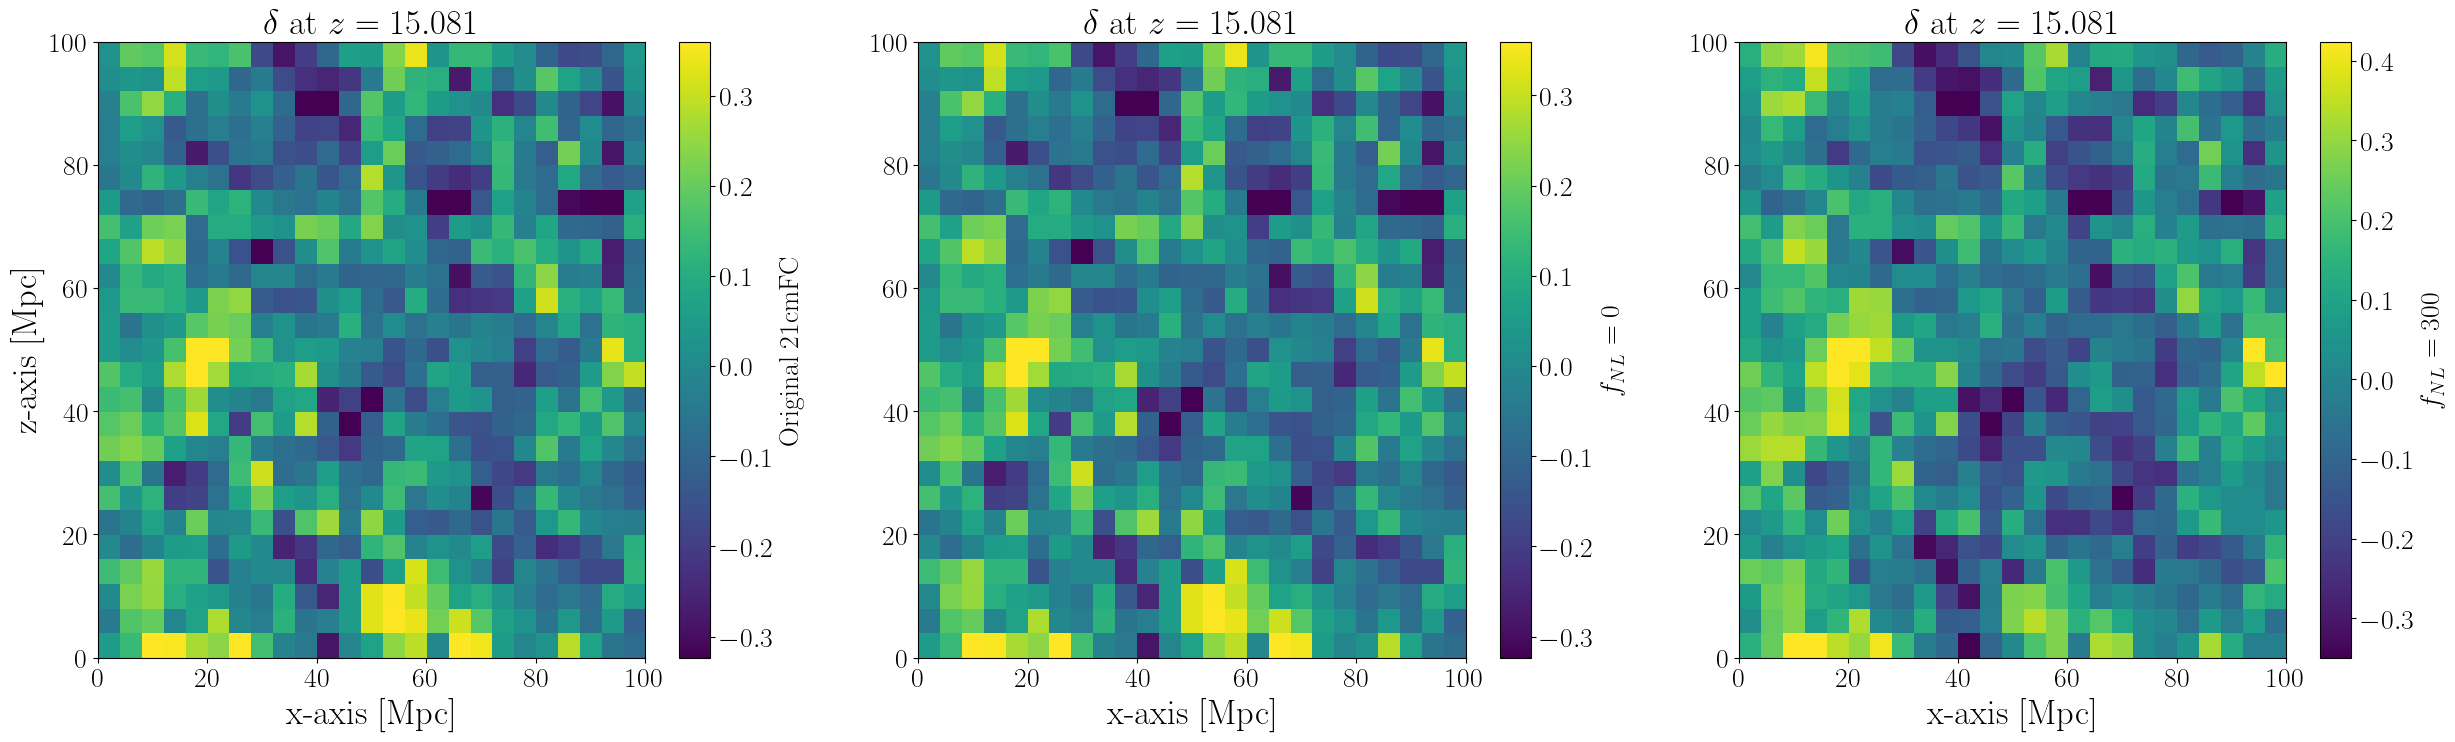

In [28]:
# Plot coeval boxes of the brightness temperature for different redshifts 

# plot the coeval boxes next to each other
fig, ax = plt.subplots(1, 3, figsize=(30, 8))

redshift = 15 

fig = plotting.coeval_sliceplot(lightcone,
                                redshift=redshift,
                                ax=ax[0],
                                slice_axis=1, # this sets along which axis the box is sliced. 0 means 'x', 1 means 'y', 2 means 'z'
                                slice_index=17, # the index of the chosen slice to be plotted, up to HII_DIM
                                cbar=True, # whether or not to have a colorbar
                                cbar_horizontal=None, # orientation of the colorbar
                                kind='density',
                                cbar_label = 'Original 21cmFC')

fig = plotting.coeval_sliceplot(lightcone_fNL0,
                                redshift=redshift,
                                ax=ax[1],
                                slice_axis=1, # this sets along which axis the box is sliced. 0 means 'x', 1 means 'y', 2 means 'z'
                                slice_index=17, # the index of the chosen slice to be plotted, up to HII_DIM
                                cbar=True, # whether or not to have a colorbar
                                cbar_horizontal=None, # orientation of the colorbar
                                kind='density',
                                cbar_label = r'$f_{NL}=0$')


fig = plotting.coeval_sliceplot(lightcone_fNL_IC,
                                redshift=redshift,
                                ax=ax[2],
                                slice_axis=1, # this sets along which axis the box is sliced. 0 means 'x', 1 means 'y', 2 means 'z'
                                slice_index=17, # the index of the chosen slice to be plotted, up to HII_DIM
                                cbar=True, # whether or not to have a colorbar
                                cbar_horizontal=None, # orientation of the colorbar
                                kind='density',
                                cbar_label = r'$f_{NL}=%g$'%cosmo_params_fNL['F_NL'])

# Omit ylabels at the two rightmost plots
ax[1].set_ylabel('')
ax[2].set_ylabel('') 

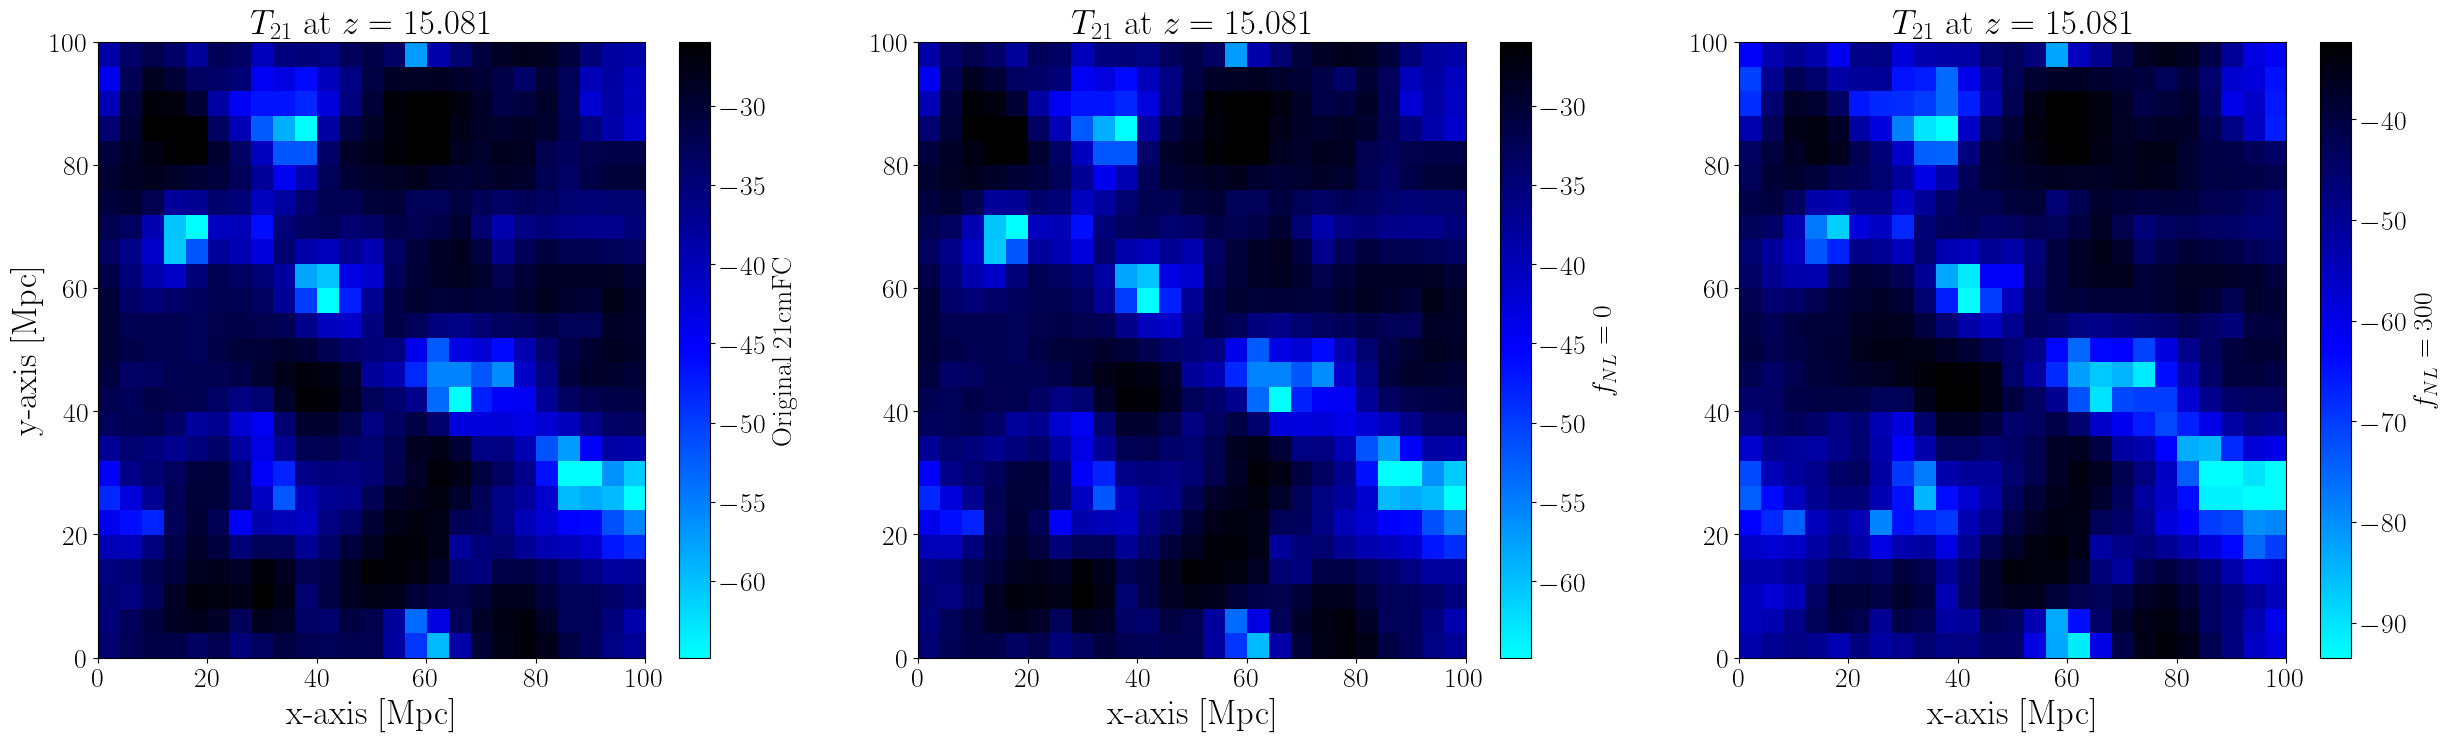

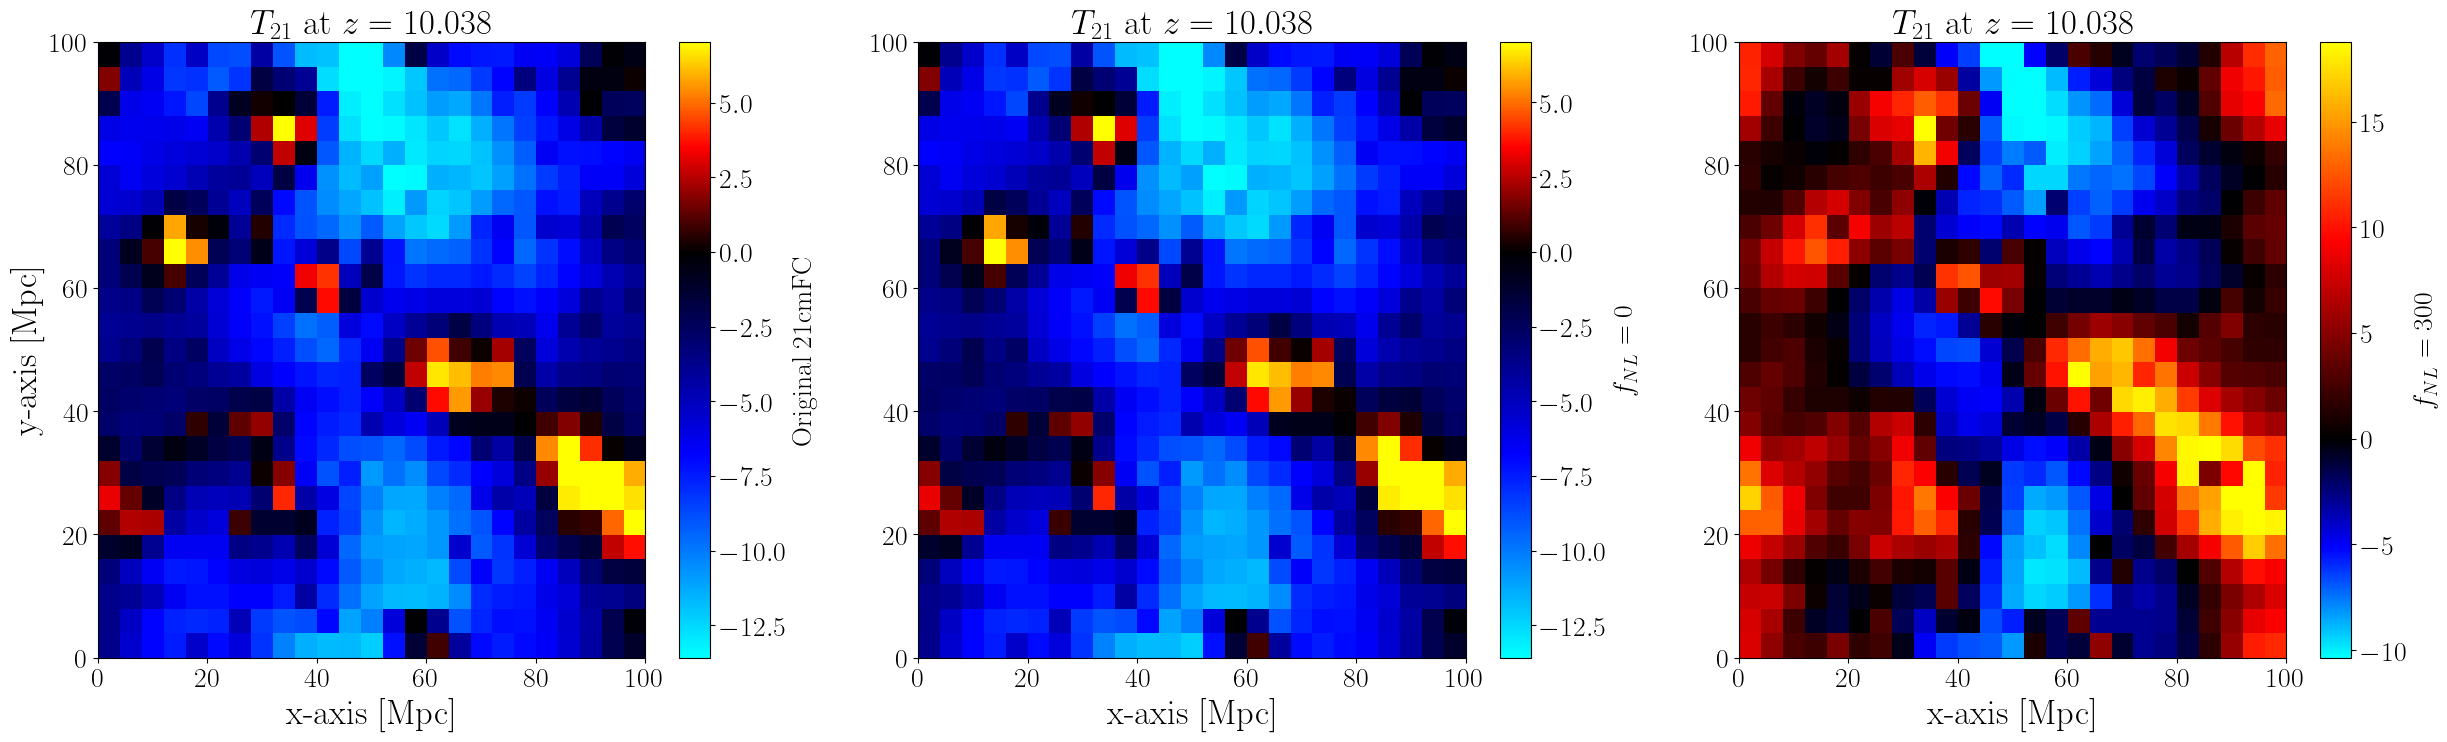

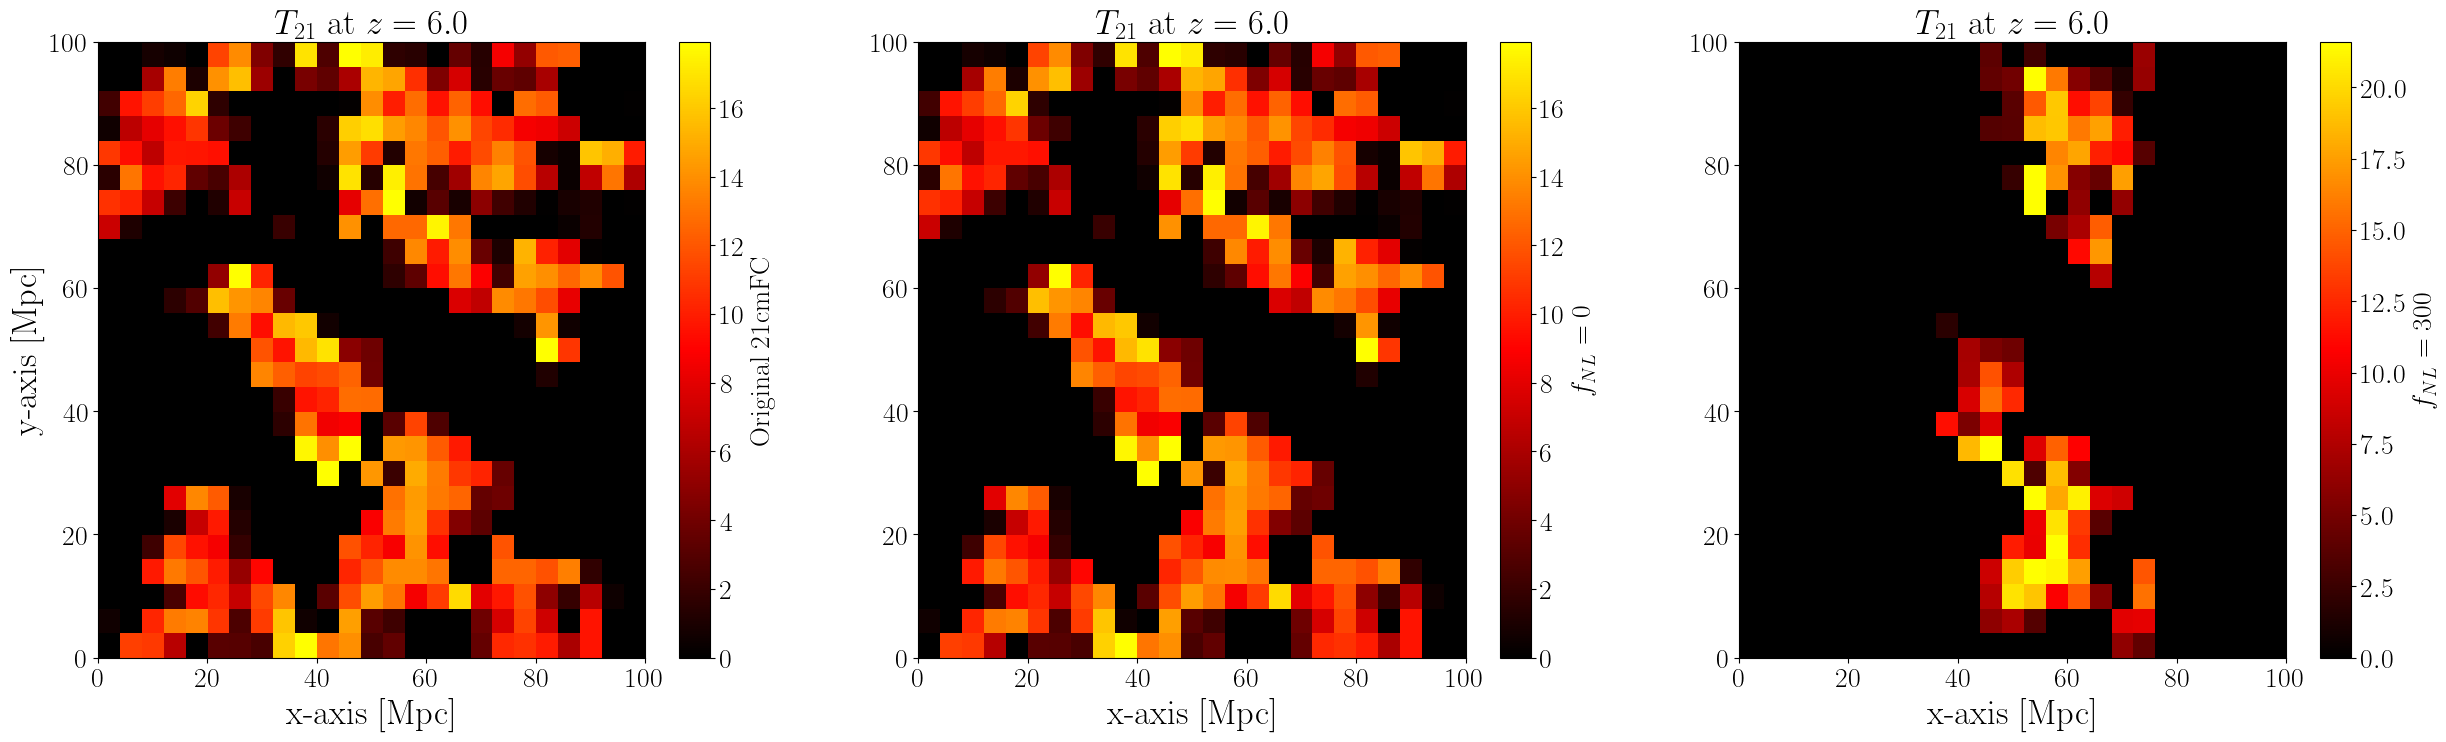

In [29]:
# Plot coeval boxes of the brightness temperature for different redshifts 

# plot the coeval boxes next to each other
fig, ax = plt.subplots(1, 3, figsize=(30, 8))

fig = plotting.coeval_sliceplot(lightcone,
                                redshift=redshift,
                                ax=ax[0],
                                cbar_label='Original 21cmFC')

fig = plotting.coeval_sliceplot(lightcone_fNL0,
                                redshift=redshift,
                                ax=ax[1],
                                cbar_label=r'$f_{NL}=0$')

fig = plotting.coeval_sliceplot(lightcone_fNL_IC,
                                redshift=redshift,
                                ax=ax[2],cbar_label=r'$f_{NL}=%g$'%cosmo_params_fNL['F_NL'])

# Omit ylabels at the two rightmost plots
ax[1].set_ylabel('')
ax[2].set_ylabel('') ;

# plot the coeval boxes next to each other
fig, ax = plt.subplots(1, 3, figsize=(30, 8))

redshift1 = 10 

fig = plotting.coeval_sliceplot(lightcone,
                                redshift=redshift1,
                                ax=ax[0],
                                cbar_label='Original 21cmFC')

fig = plotting.coeval_sliceplot(lightcone_fNL0,
                                redshift=redshift1,
                                ax=ax[1],
                                cbar_label=r'$f_{NL}=0$')

fig = plotting.coeval_sliceplot(lightcone_fNL_IC,
                                redshift=redshift1,
                                ax=ax[2],cbar_label=r'$f_{NL}=%g$'%cosmo_params_fNL['F_NL'])

# Omit ylabels at the two rightmost plots
ax[1].set_ylabel('')
ax[2].set_ylabel('') ;

# plot the coeval boxes next to each other
fig, ax = plt.subplots(1, 3, figsize=(30, 8))

redshift2 = 6 

fig = plotting.coeval_sliceplot(lightcone,
                                redshift=redshift2,
                                ax=ax[0],
                                cbar_label='Original 21cmFC')

fig = plotting.coeval_sliceplot(lightcone_fNL0,
                                redshift=redshift2,
                                ax=ax[1],
                                cbar_label=r'$f_{NL}=0$')

fig = plotting.coeval_sliceplot(lightcone_fNL_IC,
                                redshift=redshift2,
                                ax=ax[2],cbar_label = r'$f_{NL}=%g$'%cosmo_params_fNL['F_NL'])

# Omit ylabels at the two rightmost plots
ax[1].set_ylabel('')
ax[2].set_ylabel('') ;

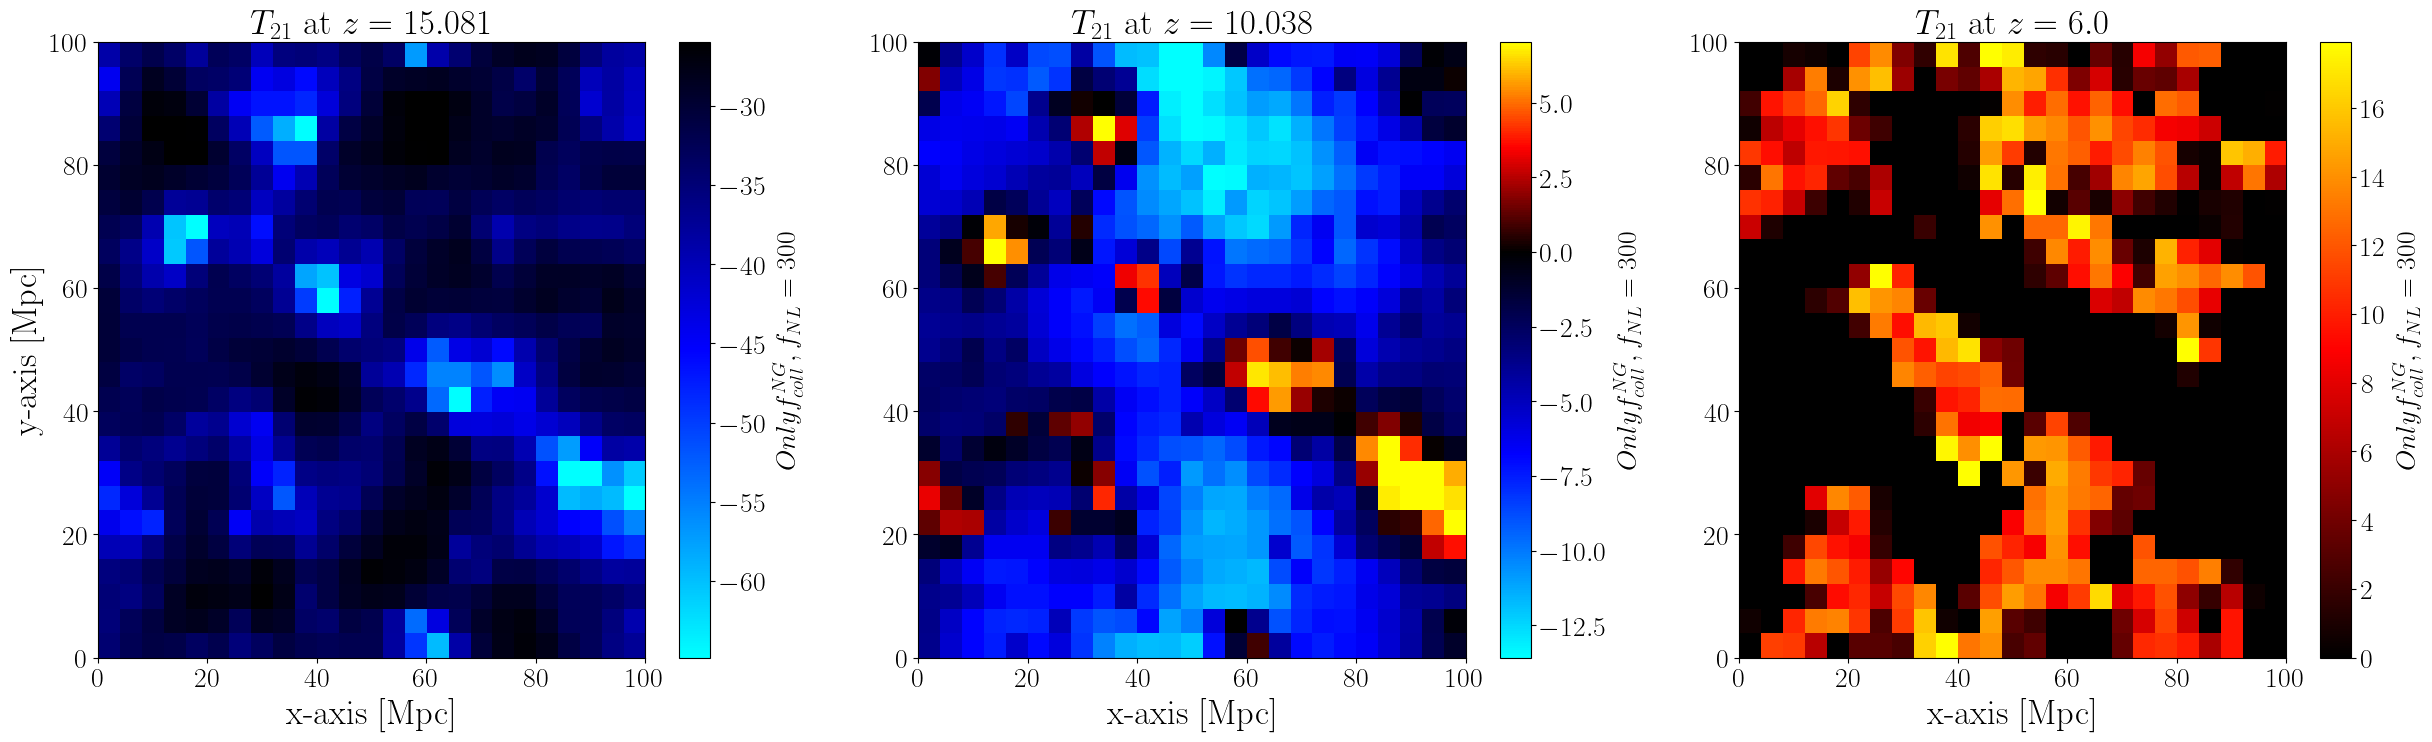

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(30, 8))

fig = plotting.coeval_sliceplot(lightcone_fNL_FCOLL,
                                redshift=15,
                                ax=ax[0],
                                cbar_label=r'$Only f^{NG}_{coll}, f_{NL}=%g$'%cosmo_params_fNL['F_NL'])

fig = plotting.coeval_sliceplot(lightcone_fNL_FCOLL,
                                redshift=10,
                                ax=ax[1],
                                cbar_label=r'$Only f^{NG}_{coll}, f_{NL}=%g$'%cosmo_params_fNL['F_NL'])

fig = plotting.coeval_sliceplot(lightcone_fNL_FCOLL,
                                redshift=6,
                                ax=ax[2],
                                cbar_label=r'$Only f^{NG}_{coll}, f_{NL}=%g$'%cosmo_params_fNL['F_NL'])

# Omit ylabels at the two rightmost plots
ax[1].set_ylabel('')
ax[2].set_ylabel('') ;

